# Image classification 

### Milton Gangopadhyay

In this second part of the notebook you will solve the image classification problem using a convolutional neural network. We are going to use the torch library.


Requirements:
- Torch
- Torchvision
- Numpy
- Matplotlib

## Convolutional Neural Networks

The algorithm to classify images using a convolutional neural network consists of three steps:

1. Load the samples
2. Define the net architecture
2. Train the model with the samples

Let's implement them but, first of all, we are going to define the device where the code will run, gpu (cuda, mps) or cpu.

In [53]:
import torch

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
    
device = torch.device(device_name)
print(f"Code runs in {device}")


Code runs in cpu


### Step 1: Load the samples

In order to feed the net in batches, we are going to extend the class Dataset from the torch library. An instance of this class will load all the samples in a dataset (train/test). The parameter `transform` in the constructor defines a sequence of transformations to be applied to the dataset images.


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import csv


class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, filename, transform = None):
        self.images, self.labels = self.load_mnist_dataset(filename)
        self.transform = transform
        
        
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)


    def load_mnist_dataset(self, filename):
        f = open(filename, 'r')
        reader = csv.reader(f, delimiter=',')
        data = []
        images = []
        labels = []
        next(reader)
        for row in reader:
            labels.append(int(row[0]))
            images.append(np.array(row[1:]).astype(np.uint8).reshape(28,28))
        return np.array(images).astype(np.float32), np.array(labels)



Now, you can load the samples:

In [55]:
train_valid_dataset = FashionDataset("res/fashion-mnist_train.csv", 
            transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionDataset("res/fashion-mnist_test.csv", 
            transform=transforms.Compose([transforms.ToTensor()]))

and visualize them:

In [56]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_valid_dataset), size=(1,)).item()
    img, label = train_valid_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In deep learning, it is usual to divide the training dataset into three datasets: train, validation and test. The former is used to update the weights of the model; the second one is used to check the performance of our model during the training stage whereas the later is used to test the accuracy of the model with unseen samples. 

In our case, the Fashion-MNIST dataset consists only on a training and a test files so we are going to create a validation dataset from the training data with a 20% of the samples in this dataset.

In [57]:
VALID_RATIO = 0.2

num_train = int((1.0 - VALID_RATIO) * len(train_valid_dataset))
num_valid = len(train_valid_dataset) - num_train

print(f"Number of samples: training = {num_train} | validation = {num_valid}")

train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [num_train, num_valid])


Number of samples: training = 48000 | validation = 12000


### Step 2: Model architecture
In the second step, we are going to define the model architecture. 
We are going to start with a toy cnn with only a convolutional layer and two fully connected layers. In torch, the net is a subclass of `nn.Module`. The architecture is declared in the constructor of the class and the way the samples are feeded to the net is defined in the `forward` method:

In [58]:
import torch.nn as nn

class ToyCNN(nn.Module):

    def __init__(self):
        super(ToyCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 32, 
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(in_features=32*12*12, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=10)


    def forward(self, x):
        out = self.conv1(x)
        # Flatten output of the previous conv layer to feed the next fc layer
        out = out.view(out.size(0), -1) 
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out



**Important**: This net is adapted to the Fashion-MNIST image size. The input size of the first fully connected layer depends on the size of the previous layer. In order to compute the output size of a convolutional or a pooling layer, take into account the following equation:

$output\_size = \dfrac{input\_size + 2 * padding - kernel\_size}{stride} + 1$

### Step 3: train the model

The last step is training the model with the provided samples. The following function trains  a convolutional neural network **one epoch** with the train and validation datasets: the weights are updated using the training samples and the loss is computed in the validation dataset.

In [59]:
def train(model, loader, f_loss, optimizer, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.train()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        targets = targets.long()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

        # Backpropagate the error to change the model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss/count, correct /count  


The following code trains the `ToyCNN` model one epoch using the `CrossEntropyLoss` as function loss and the `Adam` optimizer:

In [60]:
from torch.optim import Adam

model = ToyCNN()
model.to(device)

batch_size = 64
f_loss = nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(), lr=0.0001)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

loss, acc = train(model, train_loader, f_loss, optimizer, device)
torch.save(model, 'trained-model.pt')
print(f"Epoch 1 (training): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (training): Loss = 4.108845551609993 | Accuracy = 0.7987708333333333


The following function computes the predictions so we can use it to check the performance of our model in the validation dataset:

In [61]:
def test(model, loader, f_loss, device):
    count = 0
    total_loss = 0.0
    correct = 0

    model.eval()
    for i, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.long()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = f_loss(outputs, targets)

        # Accumulate the number of processed samples
        count += inputs.shape[0]

        # Accumulate the total loss
        total_loss += inputs.shape[0] * loss.item()

        # Compute total accuracy
        predictions = outputs.argmax(dim=1)
        correct += (predictions == targets).sum().item()

    return total_loss/count, correct /count  


In [62]:
loss, acc = test(model, valid_loader, f_loss, device)
print(f"Epoch 1 (validation): Loss = {loss} | Accuracy = {acc}")

Epoch 1 (validation): Loss = 1.6887649374008178 | Accuracy = 0.8380833333333333


#### Exercise
Write a function that trains the model for a given number of epochs. The function should output both validation loss and accuracy for each epoch. It should also save the model with the lowest validation error during the training stage and plot both the validation loss and accuracy through epochs. 

In [65]:
from torch.utils.data import DataLoader

def train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size=128, num_epochs=20, output_filename='trained-model.pt'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    history = {'train_loss': [], 'valid_loss': [], 'valid_acc': []}
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        for loader, mode in [(train_loader, 'train'), (valid_loader, 'valid')]:
            count = 0
            total_loss = 0.0
            correct = 0

            if mode == 'train':
                model.train()
            else:
                model.eval()

            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.long() 

                outputs = model(inputs)
                loss = f_loss(outputs, targets)

                count += inputs.shape[0]
                total_loss += inputs.shape[0] * loss.item()

                predictions = outputs.argmax(dim=1)
                correct += (predictions == targets).sum().item()

                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            avg_loss = total_loss / count
            acc = correct / count

            if mode == 'train':
                history['train_loss'].append(avg_loss)
            else:
                history['valid_loss'].append(avg_loss)
                history['valid_acc'].append(acc)

                if avg_loss < best_valid_loss:
                    best_valid_loss = avg_loss
                    torch.save(model, output_filename)

        print(f'Epoch {epoch+1}/{num_epochs}: train_loss = {history["train_loss"][-1]:.4f}, valid_loss = {history["valid_loss"][-1]:.4f}, valid_acc = {history["valid_acc"][-1]:.4f}')

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['valid_loss'], label='valid')
    plt.title('Loss history')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['valid_acc'])
    plt.title('Validation accuracy history')
    plt.show()

Epoch 1/20: train_loss = 0.4937, valid_loss = 0.7762, valid_acc = 0.8662
Epoch 2/20: train_loss = 0.4560, valid_loss = 0.8306, valid_acc = 0.8577
Epoch 3/20: train_loss = 0.4414, valid_loss = 0.7857, valid_acc = 0.8630
Epoch 4/20: train_loss = 0.3820, valid_loss = 0.6478, valid_acc = 0.8757
Epoch 5/20: train_loss = 0.3258, valid_loss = 0.6465, valid_acc = 0.8766
Epoch 6/20: train_loss = 0.2824, valid_loss = 0.6403, valid_acc = 0.8788
Epoch 7/20: train_loss = 0.2544, valid_loss = 0.6546, valid_acc = 0.8755
Epoch 8/20: train_loss = 0.2462, valid_loss = 0.7151, valid_acc = 0.8698
Epoch 9/20: train_loss = 0.2646, valid_loss = 0.6736, valid_acc = 0.8748
Epoch 10/20: train_loss = 0.2677, valid_loss = 0.6636, valid_acc = 0.8699
Epoch 11/20: train_loss = 0.2479, valid_loss = 0.6494, valid_acc = 0.8679
Epoch 12/20: train_loss = 0.2352, valid_loss = 0.5883, valid_acc = 0.8745
Epoch 13/20: train_loss = 0.2067, valid_loss = 0.5628, valid_acc = 0.8758
Epoch 14/20: train_loss = 0.1740, valid_loss = 

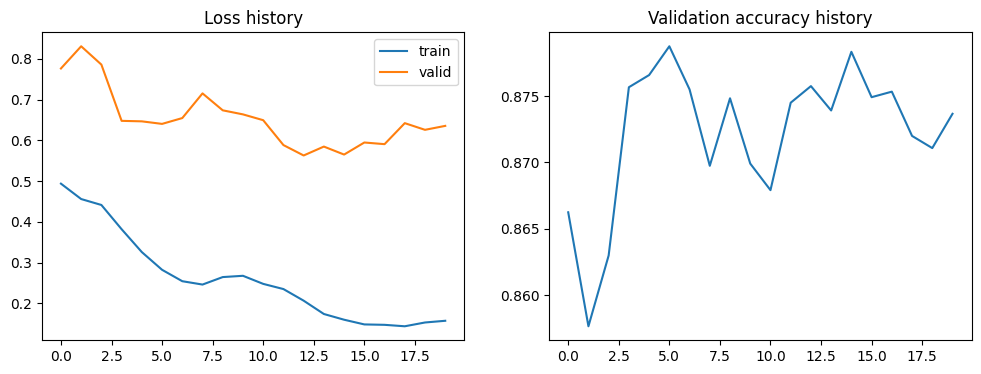

In [66]:
# IMPORTANT: adapt the batch size to your hardware requirements! 
train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128,20)

#### Exercise
Compute the success rate in the test dataset by loading the best model that have been saved.

In [67]:
model = torch.load('trained-model.pt', map_location=device)
model.to(device)

ToyCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4608, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=10, bias=True)
)

In [68]:
def compute_test_accuracy(model, test_dataset, device, batch_size=128):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model.eval()

    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            targets = targets.long()
            
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = f_loss(outputs, targets)

            # Accumulate the total loss
            total_loss += inputs.size(0) * loss.item()

            # Accumulate the number of processed samples
            total += targets.size(0)

            # Compute total accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()

    return total_loss / total, correct / total

avg_loss, test_accuracy = compute_test_accuracy(model, test_dataset, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Average Test Loss: {avg_loss:.4f}')

Test Accuracy: 88.33%
Average Test Loss: 0.5322


#### Exercise
Define another model architecture with two convolutional layers and three fully connected layers. Train the model and test the accuracy in the test dataset.

**Hint**: increase the learning rate (e.g. 0.001)

In [69]:
import torch.nn.functional as F

class FashionMNISTCNN(nn.Module):
    def __init__(self):
        super(FashionMNISTCNN, self).__init__()
        # Define two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Define three fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output layer with 10 classes for FashionMNIST

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # Reshape for fully connected layers
        x = x.view(-1, 32 * 7 * 7)
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for output layer in this case
        
        return x

# Initialize the model
model = FashionMNISTCNN()
model.to(device)

# Define the optimizer with a higher learning rate
optimizer = Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, batch_size=128, num_epochs=20, output_filename='trained-model-v2.pt')

Epoch 1/20: train_loss = 0.4741, valid_loss = 0.3203, valid_acc = 0.8836
Epoch 2/20: train_loss = 0.2866, valid_loss = 0.2884, valid_acc = 0.8960
Epoch 3/20: train_loss = 0.2459, valid_loss = 0.2715, valid_acc = 0.9012
Epoch 4/20: train_loss = 0.2198, valid_loss = 0.2923, valid_acc = 0.8954


KeyboardInterrupt: 

In [65]:
model = FashionMNISTCNN()
model.to(device)

optimizer=Adam(model.parameters(), lr=0.001)

train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128,20, 'trained-model-v2.pt')
model = torch.load('trained-model-v2.pt', map_location=device)
model.to(device)

## Write your code here
# Compute accuracy in the test dataset

ValueError: optimizer got an empty parameter list

#### Exercise
Replicate the previous architecture but include [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) before the ReLU layer and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout) between two consecutive fully conected layers. Train the  model and check if these strategies have improved the accuracy in the test dataset.

In [66]:
class FashionMNISTv2CNN(nn.Module):

    def __init__(self):
        super(FashionMNISTv2CNN, self).__init__()
        self.conv1 = None
        self.conv2 = None

        self.fc1 = None
        self.drop = None
        self.fc2 = None
        self.fc3 = None


    def forward(self, x):
        out = x
        return out


In [68]:
model = FashionMNISTv2CNN()
model.to(device)

optimizer=Adam(model.parameters(), lr=0.001)

train_model(model, train_dataset, valid_dataset, device, optimizer, f_loss, 128,20, 'trained-model-v3.pt')
model = torch.load('trained-model-v3.pt', map_location=device)
model.to(device)

# Compute accuracy in the test dataset

ValueError: optimizer got an empty parameter list